In [33]:
import pandas as pd

data = pd.read_csv('CO2_fluxes_Biomet.csv')
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop(columns=['Date.1', 'Timestamp_rounded'], inplace=True)

# remove AST from AST_Treat_XX for easier grouping, ATTENTION: repeated calls dont work
names = data.ID[data.ID.str.contains('Treat')].str.split('_')
data.loc[data.ID.str.contains('Treat'), 'ID'] = [' '.join(names[i][1:]) for i in range(len(names))]
data.loc[data['ID'].str.contains('Treat'),'ID']
data


,Date,ID,FCO2 µmol m-2 s-1,FCO2 uncertainty µmol m-2 s-1,PAR µmol m-2 s-1,PAR StD µmol m-2 s-1,AirT,AirRH,PAR,SW_in,SW_out,LW_in,LW_out,NR01_T,Rain_Tot,WS_ms_S_WVT,WindDir_D1_WVT
Date,,,,,,,,,,,,,,,,,
2018-01-23 19:23:28,2018-01-23 19:23:28,AST1P1,-9.2272,1.48210,457.5705,37.5160,9.57,61.35,827.0,373.6084,75.5403,344.2315,360.7026,9.3961,0.0,4.188,252.5
2018-03-07 16:59:17,2018-03-07 16:59:17,AST1P1,-6.4570,0.94889,1035.4533,18.9374,13.93,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:04:04,2018-03-07 17:04:04,AST1P1,-5.9518,0.86008,1083.4106,27.3755,13.93,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:08:59,2018-03-07 17:08:59,AST1P1,-6.2376,0.91240,1038.3606,52.7387,13.93,41.61,1647.0,718.5799,151.9329,293.5866,402.7068,15.4464,0.0,4.168,255.6
2018-03-07 17:16:26,2018-03-07 17:16:26,AST1P1,-6.6604,0.98303,1068.9876,22.8582,13.85,45.08,1634.0,714.3060,150.6247,293.2086,402.1044,15.2750,0.0,4.608,264.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-18 18:58:29,2019-01-18 18:58:29,SPH3P3,1.4522,0.35604,2.7473,6.1431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 18:28:58,2019-01-18 18:28:58,SPH3P3,-3.3655,0.53736,1184.5325,77.7921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-18 18:35:59,2019-01-18 18:35:59,SPH3P3,-3.0945,0.49870,1144.0790,23.0360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### __Q10 estimate from dark measurements__

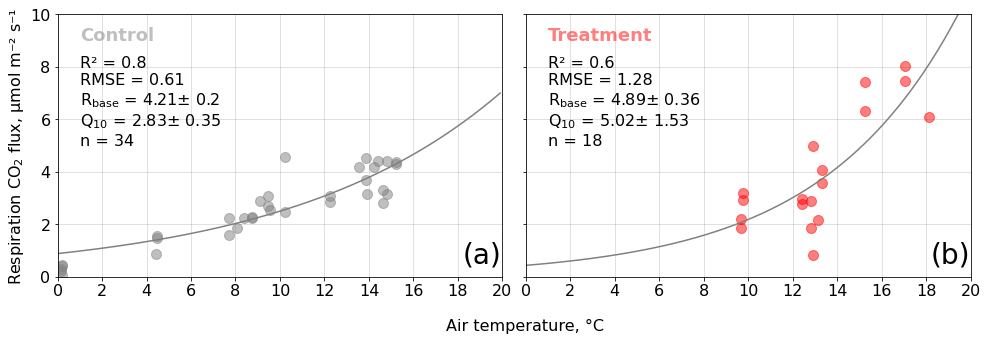

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.ticker as ticker


def Q10Model(T, Rbase, Q10):
    Tref = 15
    FCO2mod = Rbase * Q10**((T-Tref)/10)    
    return FCO2mod

def RMSE(obs, pred):
    return np.sqrt((sum((obs-pred)**2))/len(obs))
    
font = dict(size=16)
matplotlib.rc('font', **font)

Rd_params = np.empty((2,2))
Rd_params_err = np.empty((2,2))
groups = ['AST', 'Treat']
clrs = ['gray', 'red']
titles = ['Control', 'Treatment']
panelnames = ['(a)','(b)']
i = groups[0]
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)
for idx, group in enumerate(groups):


    plots = data['ID'][data['ID'].str.contains(group)]
    date = data['Date'][data['ID'].str.contains(group)]
    Rd = data.loc[data['ID'].str.contains(group), 'FCO2 µmol m-2 s-1']
    T =  data.loc[data['ID'].str.contains(group), 'AirT']
    fltr = np.logical_and(np.logical_and(data.loc[data['ID'].str.contains(group), 'PAR µmol m-2 s-1']<20,
                                         np.isfinite(Rd)
                                        ),
                          np.isfinite(T)
                         )
    Rd = Rd[fltr]
    T = T[fltr]

    
    ax[idx].plot(T, Rd, '.', color=clrs[idx], markersize=20, alpha=.5)

    popt, pcov = curve_fit(Q10Model, T, Rd, p0=[4, 2], bounds=([0, 0], [10, 10])) # rbase q10 
    perr = list(np.sqrt(np.diag(pcov)))
    
    Rd_opt = Q10Model(T, *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(Rd, Rd_opt)  
    ax[idx].plot(np.arange(0,20,.1), Q10Model(np.arange(0,20,.1), *popt), color='gray')
    ax[idx].set_xlim(0,20)
    ax[idx].set_ylim(0,10)
    ax[idx].grid(color='gray', alpha=.3)
    ax[idx].text(1, 5, f'R² = {round(r_value**2,1)}\n'
                       f'RMSE = {round(RMSE(Rd, Rd_opt),2)}\n'  
                       'R$_\mathrm{base}$ = '+f'{round(popt[0],2)}' + f'$\pm$ {round(perr[0],2)}\n'
                       'Q$_\mathrm{10}$ = '+f'{round(popt[1],2)}' + f'$\pm$ {round(perr[1],2)}\n'
                       f'n = {len(T)}')
    ax[idx].text(1, 9, titles[idx], color=clrs[idx], fontsize=18, fontweight='bold', alpha=.5)
    ax[idx].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax[idx].text(18.2,.5,panelnames[idx],fontsize=28)
    ax[0].set_ylabel('Respiration CO$_2$ flux, µmol m⁻² s⁻¹')
    Rd_params[idx,0] = popt[0]
    Rd_params[idx,1] = popt[1]
    Rd_params_err[idx, 0] = perr[0]
    Rd_params_err[idx, 1] = perr[1]
    
ax[0].set_xlabel('Air temperature, °C', x=1.05,labelpad=20)
fig.tight_layout(w_pad=0)


### __Stepwise bulk model, optimize Pmax, alpha__

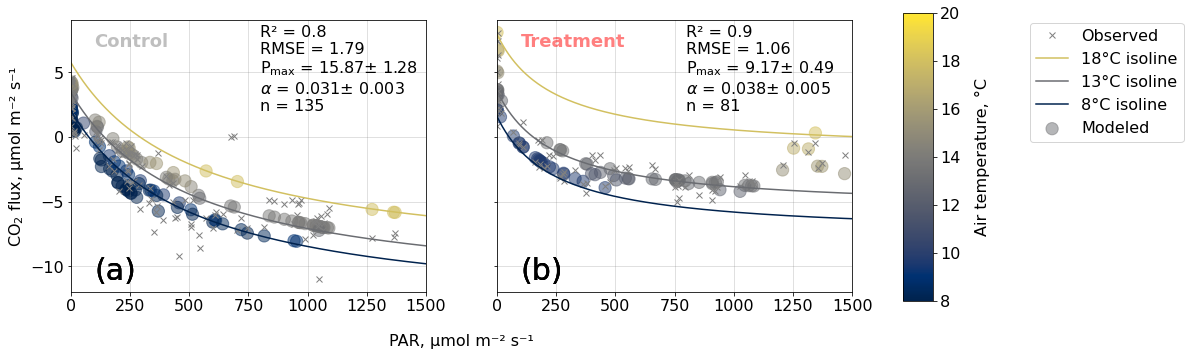

In [35]:
def LightSatModel(Indep, Pmax, alpha):
    (PAR, T, const) = Indep
    Tref = 15
    Rbase = const[0]
    Q10 = const[1]
    FCO2mod = -((Pmax*alpha*PAR)/(Pmax+alpha*PAR)) + Rbase * Q10**((T-Tref)/10)    
    return FCO2mod

LightSat_params = np.empty((2,2))
LightSat_params_err = np.empty((2,2))
groups = ['AST', 'Treat']
clrs = ['gray', 'red']
titles = ['Control', 'Treatment']
panelnames = ['(a)','(b)']
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)
for idx, group in enumerate(groups):
    FCO2 = data.loc[data['ID'].str.contains(group), 'FCO2 µmol m-2 s-1']
    PAR = data.loc[data['ID'].str.contains(group), 'PAR µmol m-2 s-1']
    T =  data.loc[data['ID'].str.contains(group), 'AirT']
    fltr = np.logical_and(np.logical_and(np.isfinite(FCO2),
                                         np.isfinite(PAR)
                                        ),
                          np.isfinite(T)
                         )
    FCO2 = FCO2[fltr]
    T = T[fltr]
    PAR = PAR[fltr]
    const = pd.Series([0]*len(PAR))
    const[:2] = Rd_params[idx,:]
    
    popt, pcov = curve_fit(LightSatModel,(PAR, T, const), FCO2, p0=[10, 0.04], bounds=([0, 0], [30, 1])) # pmax alpha
    perr = list(np.sqrt(np.diag(pcov)))    
    FCO2_opt = LightSatModel((PAR, T, const), *popt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(FCO2, FCO2_opt)
    mod_lne = ax[idx].scatter(PAR, FCO2_opt, c=T,
                       cmap='cividis',
                       s=150,
                       alpha=.5,
                       vmin=8,
                       vmax=20)
    obs_lne = ax[idx].plot(PAR, FCO2,'x', color='gray')
    
    ax[idx].set_xlim(0,1500)
    ax[idx].grid(color='gray', alpha=.3)
    ax[idx].text(100, 7, titles[idx], color=clrs[idx], fontsize=18, fontweight='bold', alpha=.5)
    ax[idx].text(800, 2, f'R² = {round(r_value**2,1)}\n'
                         f'RMSE = {round(RMSE(FCO2, FCO2_opt),2)}\n'
                         'P$_\mathrm{max}$ = '+f'{round(popt[0],2)}' + f'$\pm$ {round(perr[0],2)}\n'
                         r'$\alpha$ = '+f'{round(popt[1],3)}' + f'$\pm$ {round(perr[1],3)}\n'
                         f'n = {len(T)}')
    LightSat_params[idx,0] = popt[0]
    LightSat_params[idx,1] = popt[1]
    LightSat_params_err[idx, 0] = perr[0]
    LightSat_params_err[idx, 1] = perr[1]
        
    isoline_T_groups = [18, 13, 8]
    # get color from colormap for specific value
    norm = matplotlib.colors.Normalize(vmin=8.0, vmax=20.0)
    cmap = matplotlib.cm.get_cmap('cividis')

    for _,isoline_T in enumerate(isoline_T_groups):
        res = 1000
        isoline_xdata = np.linspace(0,1800,res)
        isoline_ydata = LightSatModel((pd.Series(np.linspace(0,1800,res)), pd.Series([isoline_T]*res), const), *popt)
        cmap(norm(isoline_T))[:3]
        ax[idx].plot(isoline_xdata, isoline_ydata, color=cmap(norm(isoline_T)))
        ax[idx].text(100,-11,panelnames[idx], fontsize=30)
        
cax = fig.add_axes([0.95, 0.1, 0.03, .8]) 
cbar = plt.colorbar(mod_lne, ax=ax[1], cax=cax)
cbar.solids.set_alpha(1)
cbar.set_label('Air temperature, °C', labelpad=15)
ax[0].set_xlabel('PAR, µmol m⁻² s⁻¹', x=1.1,labelpad=20)
ax[0].set_ylabel('CO$_2$ flux, µmol m⁻² s⁻¹')

ax[1].legend(['Observed', '18 °C isoline', '13 °C isoline','8 °C isoline','Modeled'],loc=(1.5,.55))

#plt.savefig('BulkModel.png', dpi=300,bbox_inches = 'tight')
